<a href="https://colab.research.google.com/github/ArmaanMistry/medical-advise-llama2-finetuning/blob/main/medical_advisor_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Advisor

## Install and Import required libraries

In [1]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7 --progress-bar off

In [2]:
!pip install datasets rouge_score -q

  Preparing metadata (setup.py) ... done


In [3]:
import json
import re
from pprint import pprint

import pandas as pd
import torch
from datasets import Dataset, load_dataset
from huggingface_hub import notebook_login
from peft import LoraConfig, PeftModel
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
)
from trl import SFTTrainer

In [4]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

## Login HuggingFace and Load Dataset

In [5]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineGrained).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your termin

In [6]:
dataset = load_dataset("lavita/ChatDoctor-HealthCareMagic-100k")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/542 [00:00<?, ?B/s]

(…)-00000-of-00001-5e7cb295b9cff0bf.parquet:   0%|          | 0.00/70.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/112165 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 112165
    })
})

In [7]:
MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"

## Structure the Prompt and Prepare Dataset

In [8]:
# Defining prompt

DEFAULT_SYSTEM_PROMPT = """
You are a doctor, please answer the medical questions based on the patient's description.
""".strip()

In [9]:
# Prompt for training

def generate_training_prompt(
    input: str, response: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT
) -> str:
    return f"""### Instruction: {system_prompt}

### Input:
{input.strip()}

### Response:
{response}
""".strip()

In [10]:
def generate_text(data_point):
  input_text = data_point['input']
  response_text = data_point['output']
  return {
      "input": input_text,
      "response": response_text,
      "text": generate_training_prompt(input_text, response_text),
  }

In [11]:
def process_dataset(data: Dataset):
    return (
        data.shuffle(seed=42)
        .map(generate_text)
    )

In [12]:
train_subset = dataset["train"].select(range(1000))
validation_subset = dataset["train"].select(range(1000, 1100))
test_subset = dataset["train"].select(range(1100, 1200))

dataset["train"] = process_dataset(train_subset)
dataset["validation"] = process_dataset(validation_subset)
dataset["test"] = process_dataset(test_subset)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [13]:
dataset["train"] = dataset["train"].remove_columns(
    [
        "output",
        "instruction"
    ])

In [14]:
dataset["validation"] = dataset['validation'].remove_columns([
    "output",
    "instruction"
])

In [15]:
dataset["test"] = dataset['test'].remove_columns([
    "output",
    "instruction"
])

In [16]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'response', 'text'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['input', 'response', 'text'],
        num_rows: 100
    })
    test: Dataset({
        features: ['input', 'response', 'text'],
        num_rows: 100
    })
})

## Load llama2 model

In [17]:
def create_model_and_tokenizer():
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
    )

    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        use_safetensors=True,
        quantization_config=bnb_config,
        trust_remote_code=True,
        device_map="auto",
    )

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    return model, tokenizer

In [18]:
model, tokenizer = create_model_and_tokenizer()
model.config.use_cache = False

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [19]:
model.config.quantization_config.to_dict()

{'load_in_8bit': False,
 'load_in_4bit': True,
 'llm_int8_threshold': 6.0,
 'llm_int8_skip_modules': None,
 'llm_int8_enable_fp32_cpu_offload': False,
 'llm_int8_has_fp16_weight': False,
 'bnb_4bit_quant_type': 'nf4',
 'bnb_4bit_use_double_quant': False,
 'bnb_4bit_compute_dtype': 'float16'}

## Lora Configuration and Train the model for fine-tuning

In [20]:
lora_r = 16
lora_alpha = 64
lora_dropout = 0.1
lora_target_modules = [
    "q_proj",
    "up_proj",
    "o_proj",
    "k_proj",
    "down_proj",
    "gate_proj",
    "v_proj",
]

peft_config = LoraConfig(
    r=lora_r,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    target_modules=lora_target_modules,
    bias="none",
    task_type="CAUSAL_LM",
)

In [21]:
OUTPUT_DIR = "experiments"

In [22]:
training_arguments = TrainingArguments(
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    logging_steps=1,
    learning_rate=1e-4,
    fp16=True,
    max_grad_norm=0.3,
    num_train_epochs=1,
    evaluation_strategy="steps",
    eval_steps=0.2,
    warmup_ratio=0.05,
    save_strategy="epoch",
    group_by_length=True,
    output_dir=OUTPUT_DIR,
    report_to="tensorboard",
    save_safetensors=True,
    lr_scheduler_type="cosine",
    seed=42,
)

In [23]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=4096,
    tokenizer=tokenizer,
    args=training_arguments,
)

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:427: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


### Trainer

In [24]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:1301: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  new_forward = torch.cuda.amp.autocast(dtype=torch.float16)(model_forward_func)
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss
13,2.249100,2.275796
26,1.889900,2.174699
39,1.869000,2.146016
52,2.063000,2.135981


TrainOutput(global_step=62, training_loss=2.1718137571888585, metrics={'train_runtime': 1281.0074, 'train_samples_per_second': 0.781, 'train_steps_per_second': 0.048, 'total_flos': 6036047310716928.0, 'train_loss': 2.1718137571888585, 'epoch': 0.99})

## Generate responses

In [25]:
def generate_prompt(
    input: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT
) -> str:
    return f"""### Instruction: {system_prompt}

### Input:
{input.strip()}

### Response:
""".strip()

In [26]:
from transformers import pipeline, Conversation

### Function that generates the doctor advice

In [27]:
def give_advice_conversational(model, text: str):
    inputs = tokenizer(text, return_tensors="pt").to(DEVICE)
    inputs_length = len(inputs["input_ids"][0])
    with torch.inference_mode():
        outputs = model.generate(**inputs,
                                 max_new_tokens=256,
                                 temperature=0.5,
                                 no_repeat_ngram_size=3)

    generated_text = tokenizer.decode(outputs[0][inputs_length:], skip_special_tokens=True)

    stop_words = ['Chat Doctor.', 'Chat Doctor']

    for word in stop_words:
        if word in generated_text:
            generated_text = generated_text.split(word)[0] + word
            break

    return generated_text

## Check weather medical or not?

In [28]:
import numpy as np
import pandas as pd

In [29]:
mnm_dataset = pd.read_csv('medical_non_medical_questions_dataset.csv', lineterminator='\n')

In [30]:
mnm_dataset.head()

,questions,label
0,Who will do best at the World Cup . Trinidad o...,non-medical
1,I have recently had a MRI of my brain without ...,medical
2,DAE wish they had something to fight for? I fe...,non-medical
3,hello sir my kid is 4yrs old he has been treat...,medical
4,Hello im 18 years old and im always depressed ...,medical


In [31]:
X = mnm_dataset.iloc[:, 0]
y = mnm_dataset.iloc[:, 1]

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [33]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((36852,), (36852,), (9214,), (9214,))

In [34]:
def clean_text(text):
  text = str(text)
  text = text.lower()

  # remove html
  import re
  html_removed = re.sub('<.*?>', '', text)

  # remove punctuation
  import string
  punctuation_removed = html_removed.translate(str.maketrans('', '', string.punctuation))

  # remove special characters
  pattern = r'[^a-zA-z0-9\s]'
  special_removed = re.sub(pattern, '', punctuation_removed)

  return special_removed

In [35]:
X_train = X_train.apply(clean_text)
X_test = X_test.apply(clean_text)

In [36]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# stop words
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [37]:
def lemmatizer_text(text):
  words = word_tokenize(text)
  wordnet_lemmatizer = WordNetLemmatizer()
  lemmatized_text = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]

  # stop words
  stop_words = set(stopwords.words('english'))
  filtered_words = [word for word in lemmatized_text if word not in stop_words]
  return ' '.join(filtered_words)

In [38]:
X_train = X_train.apply(lemmatizer_text)
X_test = X_test.apply(lemmatizer_text)

### Word2Vec for medical or not classificaiton of input question.

In [39]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from sklearn.metrics.pairwise import cosine_similarity

In [40]:
# Tokenizing text for Word2Vec
def tokenize(text):
    return simple_preprocess(text)

In [41]:
X_train_tokens = X_train.apply(tokenize)
X_test_tokens = X_test.apply(tokenize)

In [42]:
word2vec_model = Word2Vec(sentences=X_train_tokens, vector_size=200, window=10, min_count=1)

In [43]:
# Function to get word vector for a sentence or keyword
def get_vector(text, model=word2vec_model):
    tokens = text.split()
    word_vectors = np.zeros((model.vector_size,))
    count = 0
    for word in tokens:
        if word in model.wv:
            word_vectors += model.wv[word]
            count += 1
    if count > 0:
        word_vectors /= count
    return word_vectors

In [95]:
health_keywords = [
    "symptom", "diagnosis", "treatment", "doctor", "medicine", "pain", "surgery", "infection", "therapy", "disease", "dizziness",
    "illness", "chronic", "fever", "allergy", "surgery", "blood pressure", "anxiety", "depression", "MRI", "X-ray", "cough", "nausea",
    "vomiting", "fatigue", "pharmacy", "first aid", "cancer", "asthma", "dentist", "stroke", "fitness", "diet"
]

In [90]:
# Function to calculate similarity score between the sentence and the keywords
def calculate_similarity(sentence):
    sentence_vector = get_vector(sentence)
    highest_similarity = -1
    for keyword in health_keywords:
        keyword_vector = get_vector(keyword)
        similarity = cosine_similarity([sentence_vector], [keyword_vector])[0][0]
        if similarity > highest_similarity:
            highest_similarity = similarity
    return highest_similarity

In [91]:
# Function to classify and find the most similar keyword along with similarity score
def classify_sentence_with_keyword_similarity(sentence, model=word2vec_model, threshold=0.6):
    sentence_vector = get_vector(sentence, model)
    highest_similarity = -1
    most_similar_keyword = None

    for keyword in health_keywords:
        keyword_vector = get_vector(keyword, model)
        similarity = cosine_similarity([sentence_vector], [keyword_vector])[0][0]

        if similarity > highest_similarity:
            highest_similarity = similarity
            most_similar_keyword = keyword

    classification = 'medical' if highest_similarity > threshold else 'non-medical'

    print(f"Classification: {classification}")
    print(f"Most similar keyword: {most_similar_keyword}")
    print(f"Similarity score: {highest_similarity:.2f}")

    return classification

### ask_doctor function which returns the doctor's advice

In [47]:
# Defining general prompt

CHAT_SYSTEM_PROMPT = """
You are a doctor, please answer the medical questions based on the patient's description.
""".strip()

In [48]:
def chat_doctor_prompt(
    input: str, conversation_history, system_prompt: str = CHAT_SYSTEM_PROMPT
) -> str:
    history_str = "\n".join(conversation_history)

    return f"""### Instruction: {system_prompt}
For context, I am providing the conversation history below. Refer to this history when responding to the patient's description:
{history_str}

### Input:
{input.strip()}

### Response:
""".strip()

In [49]:
def ask_doctor(question_text):
  classified_ques_type = classify_sentence_with_keyword_similarity(question_text)
  if classified_ques_type == 'non-medical':
    return 'Sorry, I can only provide guidance on healthcare-related questions.'
  elif classified_ques_type == 'medical':
    prompt_text = generate_prompt(question_text)
    advice = give_advice_conversational(model, prompt_text)
    # advice = advice.strip().split("\n")[0]
    return advice

### Word2Vec for greeting or not classification of the input question

In [50]:
# Tokenizing text for Word2Vec
def tokenize_greeting(text):
    return simple_preprocess(text)

In [51]:
X_train_tokens = X_train.apply(tokenize_greeting)
X_test_tokens = X_test.apply(tokenize_greeting)

In [52]:
word2vec_greeting_model = Word2Vec(sentences=X_train_tokens, vector_size=200, window=10, min_count=1)

In [53]:
# Function to get word vector for a sentence or keyword
def get_vector_greeting(text, model=word2vec_greeting_model):
    tokens = text.split()
    word_vectors = np.zeros((model.vector_size,))
    count = 0
    for word in tokens:
        if word in model.wv:
            word_vectors += model.wv[word]
            count += 1
    if count > 0:
        word_vectors /= count
    return word_vectors

In [100]:
greeting_keywords = [
    "hi", "Hi", "Hello", "Hey", "hello", "hey", "greetings", "good morning", "good afternoon", "good evening", "what's up", "hi there",
    "hey there", "good day", "yo", "sup", "morning", "good to see you", "hello doctor", "hi doctor",
    "good morning doctor", "hey doctor", "greetings", "thanks", "thank you", "welcome"
]

In [55]:
# Function to calculate similarity score between the sentence and the keywords
def calculate_similarity_greeting(sentence):
    sentence_vector = get_vector_greeting(sentence)
    highest_similarity = -1
    for keyword in greeting_keywords:
        keyword_vector = get_vector_greeting(keyword)
        similarity = cosine_similarity([sentence_vector], [keyword_vector])[0][0]
        if similarity > highest_similarity:
            highest_similarity = similarity
    return highest_similarity

### function that returns greeting or not

In [56]:
# Function to classify and find the most similar keyword along with similarity score
def is_greeting(sentence, model=word2vec_greeting_model, threshold=0.46):
    sentence_vector = get_vector_greeting(sentence, model)
    highest_similarity = -1
    most_similar_keyword = None

    for keyword in greeting_keywords:
        keyword_vector = get_vector_greeting(keyword, model)
        similarity = cosine_similarity([sentence_vector], [keyword_vector])[0][0]

        if similarity > highest_similarity:
            highest_similarity = similarity
            most_similar_keyword = keyword

    classification = 'greeting' if highest_similarity > threshold else 'not-greeting'

    print(f"Classification: {classification}")
    print(f"Most similar keyword: {most_similar_keyword}")
    print(f"Similarity score: {highest_similarity:.2f}")

    return classification

## Greeting Prompt Preparation

In [57]:
# Defining general prompt

GENERAL_SYSTEM_PROMPT = """
You are a chatbot responsible for responding to greetings and polite exchanges. Reply accordingly to the following:

- If the user says "hi", "hello", "hey", "good morning", or similar greetings, respond with a polite and friendly greeting.
- If the user says "thanks", "thank you", or expresses gratitude, respond politely with a variation of "You're welcome" or "Glad I could help."

For other messages, guide the user to ask medical-related questions if relevant.
""".strip()

In [58]:
def generate_prompt_general(
    input: str, system_prompt: str = GENERAL_SYSTEM_PROMPT
) -> str:
    return f"""### Instruction: {system_prompt}

### Input:
{input.strip()}

### Response:
""".strip()

In [59]:
def ask_general(question_text):
  prompt_text = generate_prompt_general(question_text)
  answer = give_advice_conversational(model, prompt_text)
  return answer

## LangGraph Implementation

In [60]:
pip install langgraph langchain_community -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.5/113.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.0/408.0 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.9/296.9 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.7 MB/s eta 0:00:00


In [61]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from typing import Any, List, TypedDict
from pydantic import BaseModel

### The Agent

In [69]:
# Define AgentState to hold conversation messages
class AgentState(TypedDict):
    user_input: str
    medical_intent: bool
    greeting_intent: bool
    response: str

class Agent:
    def __init__(self, model):
        self.conversation_history = []  # Track conversation history
        self.graph = StateGraph(AgentState)

        # Define the state graph nodes
        self.graph.add_node("ask_user", self.ask_user)
        self.graph.add_node("check_medical", self.check_medical)
        self.graph.add_node("ask_doctor", self.ask_doctor)
        self.graph.add_node("check_greeting", self.check_greeting)
        self.graph.add_node("ans_greeting", self.ans_greeting)
        self.graph.add_node("static_idk_msg", self.static_idk_msg)

        # Define edges based on conditions
        self.graph.add_conditional_edges("check_medical", lambda state: state['medical_intent'], {True: "ask_doctor", False: "check_greeting"})
        self.graph.add_conditional_edges("check_greeting", lambda state: state['greeting_intent'], {True: "ans_greeting", False: "static_idk_msg"})

        # Continue conversation paths
        self.graph.add_edge("ask_user", "check_medical")
        self.graph.add_edge("ask_doctor", END)
        self.graph.add_edge("ans_greeting", END)
        self.graph.add_edge("static_idk_msg", END)

        # Set entry point
        self.graph.set_entry_point("ask_user")

        self.chatbot = self.graph.compile()
        self.model = model

    def ask_user(self, state: AgentState):
        user_input = state["user_input"]
        return state

    def check_medical(self, state: AgentState):
        user_input_new = state['user_input']
        medical_classification = classify_sentence_with_keyword_similarity(user_input_new)
        if medical_classification == 'medical':
          state['medical_intent'] = True
        else:
          state['medical_intent'] = False

        print(f"check_medical state: {state}")
        return state

    def ask_doctor(self, state: AgentState):
        user_input = state['user_input']
        if state['medical_intent'] == True:
          to_ask = chat_doctor_prompt(user_input, self.conversation_history)
          prompt_text = generate_prompt(to_ask)
          advice = give_advice_conversational(self.model, prompt_text)

          state['response'] = advice

          # Save the model response to conversation history
          self.conversation_history.append(f"User: {user_input}")
          self.conversation_history.append(f"Model: {advice}")

        print(f"ask_doctor state: {state}")
        return state

    def check_greeting(self, state: AgentState):
        user_input = state['user_input']
        greeting_check = is_greeting(user_input)
        if greeting_check == 'greeting':
          state['greeting_intent'] = True
        else:
          state['greeting_intent'] = False

        print(f"check_greeting state: {state}")
        return state

    def ans_greeting(self, state: AgentState):
        user_input = state['user_input']
        if state['greeting_intent'] == True:
          prompt_text = generate_prompt_general(user_input)
          answer = give_advice_conversational(self.model, prompt_text)
          state['response'] = answer

          # Save the model response to conversation history
          self.conversation_history.append(f"User: {user_input}")
          self.conversation_history.append(f"Model: {answer}")

        print(f"ans_greeting state: {state}")
        return state

    def static_idk_msg(self, state: AgentState):
        if state['medical_intent'] == False and state['greeting_intent'] == False:
          idk_msg = "Sorry, I can only provide guidance on healthcare-related questions."
          state['response'] = idk_msg

          # Save the model response to conversation history
          user_input = state['user_input']
          self.conversation_history.append(f"User: {user_input}")
          self.conversation_history.append(f"Model: {idk_msg}")

        print(f"static_idk_msg state: {state}")
        return state

In [70]:
agent = Agent(model)

### Run CHATBOT here

In [101]:
def start_chat():
  while True:
      user_input = input("User: ")
      if user_input.lower() == "exit":
          print("Bot: Goodbye!")
          agent.conversation_history = []
          break

      # Pass user input to the chatbot
      result = agent.chatbot.invoke({"user_input": user_input})

      # Output the bot's response
      print(f"Bot: {result['response']}")

In [102]:
start_chat()

User: hi
Classification: non-medical
Most similar keyword: chronic
Similarity score: 0.42
check_medical state: {'user_input': 'hi', 'medical_intent': False}
Classification: greeting
Most similar keyword: hi
Similarity score: 1.00
check_greeting state: {'user_input': 'hi', 'medical_intent': False, 'greeting_intent': True}


/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


ans_greeting state: {'user_input': 'hi', 'medical_intent': False, 'greeting_intent': True, 'response': '\nHi! Welcome to Chat Doctor.'}
Bot: 
Hi! Welcome to Chat Doctor.
User: exit
Bot: Goodbye!


In [ ]:
# User: Hey, what's up
# User: Hi, I’ve been managing diabetes for a few years now, but lately, I’ve been feeling more tired than usual. I’m also noticing that my blood sugar levels have been harder to control, fluctuating between high and low despite sticking to my medication and diet. I haven’t experienced any serious symptoms like blurry vision or foot pain, but my energy levels are low, and I’m more irritable. Could this be a sign of something more serious? Why is my blood sugar becoming unpredictable?
# User: Can it be treated?
# User: What diet should I follow?
# User: I mean, what kind of food and fruits should I consider eating?
# User: Should I buy a new car or an old one
# User: When was 'Pirates of Caribbean' released?
# User: What is Currency?
# User: Who is Amitabh Bachchan?
# User: Computer
# User: Thanks, this was helpful!

### The Graph Representation (Workflow)

In [79]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [82]:
!apt-get install -y graphviz graphviz-dev -q
!pip install pygraphviz --force-reinstall -q

Reading package lists...
Building dependency tree...
Reading state information...
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [83]:
import pygraphviz as pgv

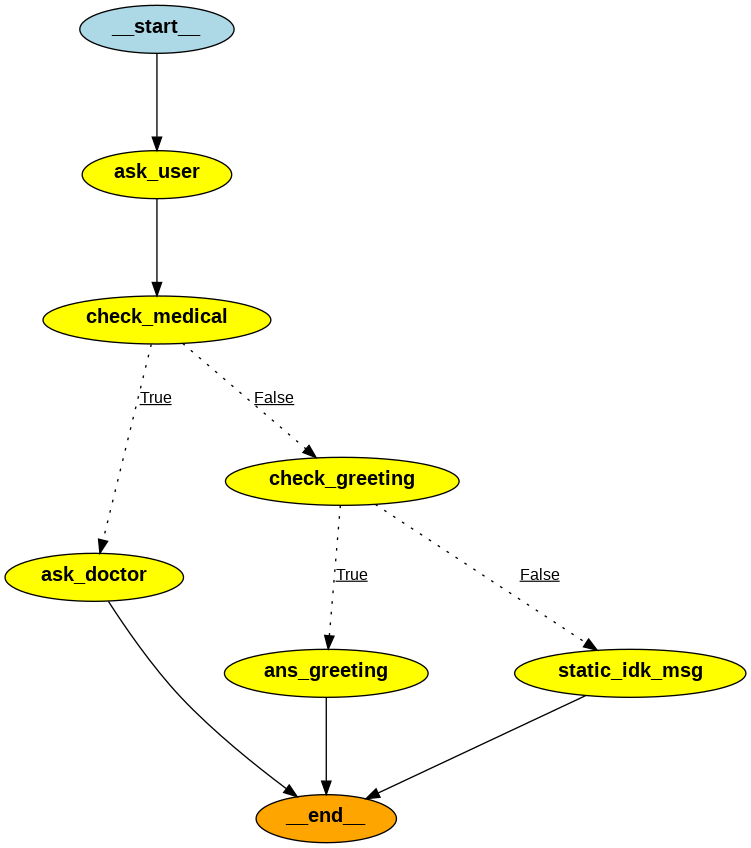

In [84]:
from IPython.display import Image
import langgraph

Image(agent.chatbot.get_graph().draw_png())